# Visa Status

Im folgenden soll der Visastatus im Bezug zu anderen Faktoren gesetzt werden.
Zuerst wird betrachtet, wie viele Anträge angenommen bzw. abgelehnt werden.

In [47]:
import cleanup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
plt.style.use('../own_style.mplstyle')

In [48]:
# Falls der bereinigte Datensatz noch nicht vorliegt:
#cleanup.generate_cleaned_df("../data/us_perm_visas.csv", "../data/")


In [49]:
col_list = ["case_status", "employer_city", 'decision_date']
visas_df = pd.read_csv('../data/us_perm_visas_cleaned.csv', usecols=col_list)

In [50]:
visas_df.dtypes

decision_date    object
case_status      object
employer_city    object
dtype: object

In [51]:
visas_df ["decision_date"]=pd.to_datetime(visas_df["decision_date"])

In [52]:
visas_df.dtypes

decision_date    datetime64[ns]
case_status              object
employer_city            object
dtype: object

In [53]:
visas_df.head()

,decision_date,case_status,employer_city
0,2012-02-01,Certified,NEW YORK
1,2011-12-21,Denied,CARLSTADT
2,2011-12-01,Certified,GLEN ALLEN
3,2011-12-01,Certified,FLUSHING
4,2012-01-26,Certified,ALBANY


In [54]:
visas_df.tail()

,decision_date,case_status,employer_city
374357,2016-12-30,Withdrawn,ANAHEIM
374358,2016-12-30,Withdrawn,REDMOND
374359,2016-12-30,Withdrawn,YPSILANTI
374360,2016-12-30,Withdrawn,PHOENIX
374361,2016-12-30,Withdrawn,SANTA CLARA


Überprüfung der Spalte case_status, da sie Informationen über den jeweiligen Visumsantrag getroffene Entscheidung enthält.

In [55]:
for value in visas_df.case_status.unique():
    print(len(visas_df[visas_df['case_status'] == value])," occurrences of status '{}'".format(value))

181933  occurrences of status 'Certified'
25649  occurrences of status 'Denied'
148586  occurrences of status 'Certified-Expired'
18194  occurrences of status 'Withdrawn'


Der Datensatz enthält 18.194 Fälle die zurückgezogen wurden 'withdrawn'. Da diese Fälle nicht relevant sind werden sie aus dem Datensatz gelöscht.

In [56]:
visas_df= visas_df[visas_df.case_status != 'Withdrawn']

Der Status 'certified' und der Status 'certified-expired' werden zu dem Wert 'certified' zusammengefasst, sodass nur noch die Werte 'certified' und 'denied' enthalten sind.

Antragssteller des Visas haben nach Erhalt des Status 'certified' 6 Monate Zeit, bevor es abläuft und in den Status 'certified-expired' übergeht.

In [57]:
visas_df.loc[visas_df.case_status == 'Certified-Expired', 'case_status'] = 'Certified'
visas_df.case_status.value_counts()

Certified    330519
Denied        25649
Name: case_status, dtype: int64

25.649 Visa Bewerbungen wurden abgelehnt (7,2%). Jetzt werden Zeilen und Spalten entfernt, welche NaN Werte enthalten.

In [58]:
visas_df = visas_df.dropna(axis=1, how='all')
visas_df = visas_df.dropna(axis=0, how='all');

visas_df.shape

(356168, 3)

Alle NaN Werte wurden entfernt.

In [59]:
for column in visas_df.columns:
    print("Attribute '{}' contains ".format(column),  visas_df[column].isnull().sum().sum(), "missing values")

Attribute 'decision_date' contains  0 missing values
Attribute 'case_status' contains  0 missing values
Attribute 'employer_city' contains  10 missing values


Einfügen der Spalte Antragsjahr. Dies soll dann in einem Balkendiagramm dargestellt werden um den Verlauf visualisieren zu können.

In [60]:
visas_df['year'] = visas_df['decision_date'].dt.year

Die Visaeinträge werden nach Jahr und Status gruppiert, sowie zusammengezählt.
Anschließend wird das Format geändert, um im Rahmen eines Balkendiagrammes visualisiert werden zu können.

In [61]:
year_status_df = visas_df.groupby(["year", "case_status"])["case_status"].count().to_frame().unstack(fill_value=0).stack(level = 0).reset_index()
del year_status_df["level_1"]

In [62]:
year_status_df = year_status_df.set_index("year",drop = True )

[Text(0, 0.5, 'Number of Visa applications')]

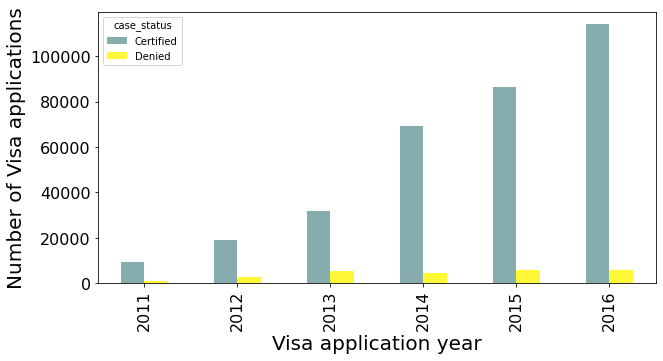

In [63]:
ax = year_status_df.plot(kind = "bar", figsize=(10,5))
ax.set(xlabel='Visa application year')
ax.set(ylabel='Number of Visa applications')

Die Anzahl der Visa Applications nimmt jedes Jahr zu. Die Anzahl der abgelehnten Anträge scheint dagegen seit 2013 zu stagnieren, bzw. ging 2014 leicht zurück.

In welchen Städten werden die meisten Visa Applications gestellt?

In [64]:
visas_df['employer_city'] = visas_df['employer_city'].str.upper()
visas_df['employer_city'].value_counts().head(20)

NEW YORK           17212
COLLEGE STATION    11985
SANTA CLARA        10519
SAN JOSE            9150
REDMOND             8485
MOUNTAIN VIEW       8121
HOUSTON             6720
SAN FRANCISCO       6352
SUNNYVALE           6113
PLANO               5607
CHICAGO             5564
SEATTLE             5052
EDISON              4056
LOS ANGELES         4047
SAN DIEGO           3702
DALLAS              3693
PHILADELPHIA        3526
CUPERTINO           3310
PALO ALTO           3229
IRVING              3144
Name: employer_city, dtype: int64

Die beliebtesten Städte waren in den letzten Jahren New York, College Station, Santa Clara, San Jose und Radmond.
Es erfolgt eine grafische Darstellung der Anzahl der Visa Bewerbungen je Jahr in Kombination mit den beliebtesten Visa Städten.

In [65]:
topDf = visas_df["employer_city"].value_counts().nlargest(
    20).reset_index()
topDf.columns = ["employer_city", 'count']
topDf = topDf.set_index(["employer_city"])
year_city_df = visas_df.loc[
    visas_df["employer_city"].isin(topDf.reset_index()["employer_city"])]

In [66]:
year_city_df = year_city_df.groupby(["employer_city", "year"])["employer_city"].count().to_frame().unstack(fill_value=0).stack(level = 0).reset_index()
del year_city_df["level_1"]

In [67]:
year_city_df = year_city_df.set_index("employer_city",drop = True )

Die Darstellung soll nach absteigender Antragsanzahl je Stadt angeordnet werden.

In [68]:
year_city_df["sum"] = year_city_df[2011]+year_city_df[2012]+year_city_df[2013]+year_city_df[2014]+year_city_df[2015]+year_city_df[2016]

In [69]:
year_city_df = year_city_df.sort_values(by="sum", ascending=False)

In [70]:
del year_city_df["sum"]

[Text(0, 0.5, 'Number of Visa applications')]

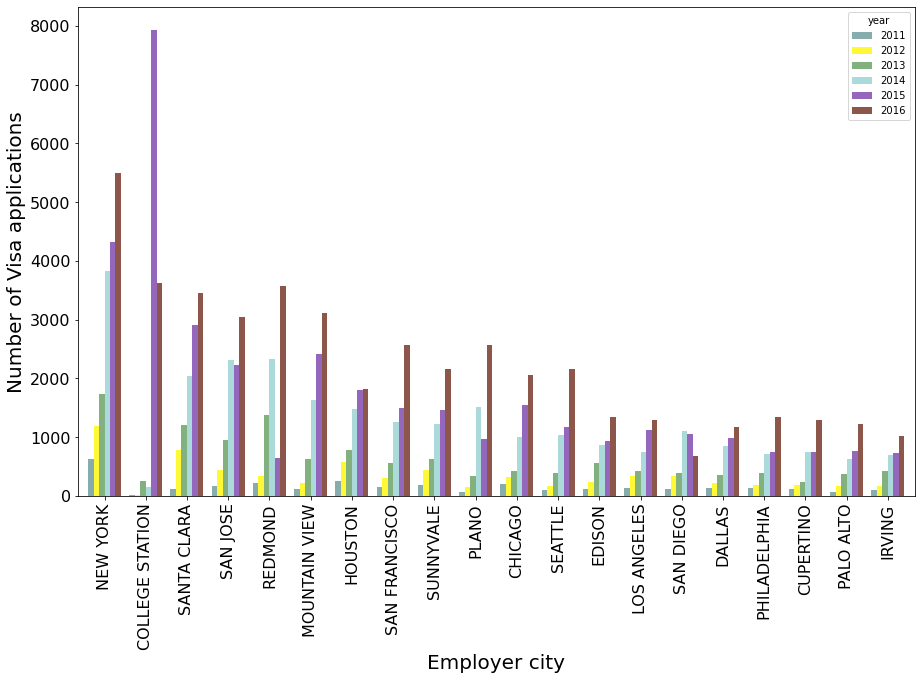

In [71]:
ax = year_city_df.plot(kind = "bar", figsize=(15,9), width=0.8)
ax.set(xlabel='Employer city')
ax.set(ylabel='Number of Visa applications')

Die Stadt College Station war im Jahr 2015 besonders beliebt. 2014 und 2016 war New York am beliebtesten. Allgemein ist ein ansteigender Trend der Visa Applications zu beobachten.

# Entwicklung der Annahmequote

Im Nachgang soll ermittelt werden, wie sich die Ablehnungsquote im Zeitverlauf entwickelt hat.
Dafür wird der Case Status, auf Certified und Denied abgeändert.

In [72]:
col_list = ["case_status", "case_received_date", "decision_date"]
visas_df = pd.read_csv('../data/us_perm_visas_cleaned.csv', usecols=col_list)


C:\Users\andre\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [73]:
visas_df =  cleanup.convert_case_status_to_certified_or_denied(visas_df)

In [74]:
visas_df['decision_date'] = pd.to_datetime(visas_df["decision_date"])
visas_df
visas_df["decision_date_year"] = visas_df["decision_date"].dt.year

In [75]:
acceptanceRate_df = pd.DataFrame()
acceptanceRate_df = visas_df.groupby(["decision_date_year", "case_status"])["case_status"].count()

In [76]:
acceptanceRate_df = acceptanceRate_df.to_frame().unstack()

In [77]:
acceptanceRate_df

case_status       
case_status          Certified Denied
decision_date_year                   
2011                      9474   1128
2012                     19116   2838
2013                     32040   5433
2014                     69458   4423
2015                     86404   5934
2016                    114027   5893

In [78]:
acceptanceRate_df = acceptanceRate_df.reset_index()

In [79]:
acceptanceRate_df= acceptanceRate_df.set_index("decision_date_year")

In [80]:
acceptanceRate_df = acceptanceRate_df["case_status"]


In [81]:
acceptanceRate_df["relation"] = acceptanceRate_df["Denied"]/(acceptanceRate_df["Certified"]+ acceptanceRate_df["Denied"])


Es wurde eine Kennzahl für die Ablehnungsquote berechnet.

In [82]:
acceptanceRate_df

case_status,Certified,Denied,relation
decision_date_year,,,
2011,9474,1128,0.106395
2012,19116,2838,0.129270
2013,32040,5433,0.144984
2014,69458,4423,0.059867
2015,86404,5934,0.064264
2016,114027,5893,0.049141


Die ermittelten Ergebnisse werden in Form eines Liniendiagramms ausgegeben.

[Text(0, 0.5, 'Rate of decline')]

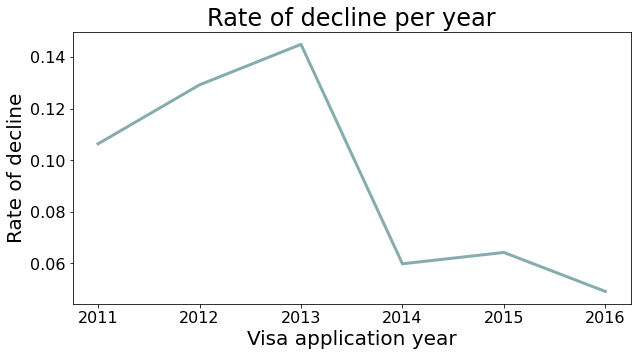

In [83]:
ax = acceptanceRate_df["relation"].plot(figsize=(10,5), title = "Rate of decline per year")
ax.set(xlabel='Visa application year')
ax.set(ylabel='Rate of decline')

Es kann festgehalten werden, dass die Ablehnungsquote rückläufig ist.